# CW01 - Non-zoomed analysis template (linear regression)


## Imports

In [77]:
# Makes it easier to debug
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
import numpy as np
import pylab as plt
import torch
import swyft

In [81]:
device = 'cuda'

## Model and prior

In [138]:
N = 64  # Number of data bins
SIGMA = 1.0  # Measurement uncertainty

def spec(a, b):
    return a+np.linspace(0, 10, N)*b

def model(v):
    return dict(y = spec(v[0], v[1]))

def noise(sim, v, sigma = SIGMA):
    return dict(y = sim['y'] + np.random.randn(N)*sigma)

In [139]:
sim = swyft.Simulator(model, 2, dict(y=(N,)))

In [140]:
low = -10 * np.ones(2)
high = 20 * np.ones(2)
prior = swyft.get_uniform_prior(low, high)

## Training and validation dataset

In [141]:
Ntrain = 10000

store = swyft.Store.memory_store(sim)
store.add(Ntrain, prior)
store.simulate()

Creating new store.
Store: Adding 9836 new samples to simulator store.


In [142]:
dataset = swyft.Dataset(Ntrain, prior, store, simhook = noise)

## Inference network and training

In [143]:
class Head(torch.nn.Module):
    def __init__(self, sim_shapes):
        super().__init__()
        self.n_features = 2
        
        self.onl_f = swyft.OnlineNormalizationLayer(torch.Size([N,]))
        self.l = torch.nn.Linear(N, 2)

    def forward(self, obs):
        x=obs['y']
        #x = self.onl_f(x)
        f = self.l(x)

        return f

In [144]:
network_1d = swyft.get_marginal_classifier(
    observation_key="y",
    marginal_indices=((0,), (1,)),
    observation_shapes={'y': (64,)},
    n_parameters=2,
    hidden_features=256,
    num_blocks=2,
)

mre_1d = swyft.MarginalRatioEstimator(
    marginal_indices=((0,), (1,)),
    network=network_1d,
    device=device,
)

In [117]:
mre_1d.train(dataset, batch_size = 64, max_epochs = 3);

training: lr=0.0005, epoch=3, validation loss=0.7118


## Results

In [111]:
post = swyft.MarginalPosterior(mre_1d, prior)

In [112]:
v0 = np.array([0.0, 0])
obs0 = noise(model(v0), v0)

In [113]:
samples = post.weighted_sample(10000, obs0, batch_size = 128)

In [114]:
# Estimate poster mean
v = samples.v[:,0]
w = samples.weights[(0,)]
m = sum(w*v)/sum(w)
#m = -0.5

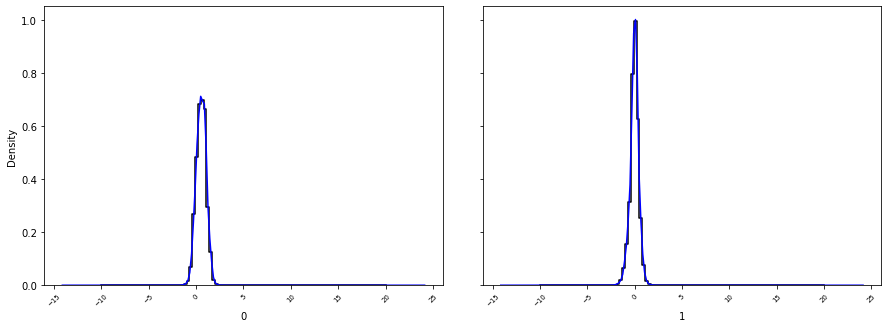

In [115]:
swyft.hist1d(samples, kde = True, figsize = (15, 5));